In [3]:
# Load the libraries
library(dplyr)
library(ggplot2)
library(ggpubr)
library(pROC)      
library(caret)        
library(ggplot2)     
library(gridExtra)   
library(ggpubr)

# Set seed for reproducibility
set.seed(123)

Loading required package: pacman



In [5]:
# Load main dataset (adjust path if needed)
data <- read.csv("MS986 Assignment 2 BBN Modelling Data Set v2.csv")
# Remove rows with any NA values
data <- na.omit(data)

In [7]:
head(data)

,srs_pcv.failure,srs_coliform,srs_colony22,srs_colony37,srs_ecoli,srs_free.chlorine,srs_icc,srs_tcc,srs_total.chlorine,srs_voloutcap,⋯,wtw_rgf,wtw_pressure.filters,wtw_slow.sand.filters,wtw_gac.filters,wtw_filters,wtw_ph.adjustment,wtw_phosphate.dosing,wtw_ozonation,wtw_manganese.removal,srs_sample.month
,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,0,0,0,0,0,0.3465509,1258,1778,0.3965509,0.3065509,⋯,1,0,0,0,0,1,1,0,0,5
2,0,0,0,0,0,0.4572124,748,1348,0.4572124,0.3172124,⋯,1,0,0,0,0,1,1,0,0,4
3,0,0,0,0,0,0.3772853,4713,5873,0.3972853,0.3372853,⋯,1,0,0,0,0,1,1,0,0,9
4,0,0,0,0,0,0.5208208,330,930,0.6308208,0.3708208,⋯,1,0,0,0,0,1,1,0,0,11
5,0,0,0,0,0,0.4801682,324,744,0.5601682,0.3001682,⋯,1,0,0,0,0,1,1,0,0,12
6,0,0,0,0,0,0.5798390,122,562,0.6698390,0.3698390,⋯,1,0,0,0,0,1,1,0,0,12


In [115]:
# -------------------------------
# Shell 3: Data Cleaning & Setup (Modified Target Conversion)
# -------------------------------

# Load main dataset (adjust path if needed)
data <- read.csv("MS986 Assignment 2 BBN Modelling Data Set v2.csv")
# Remove rows with any NA values
data <- na.omit(data)

# Convert 4 character columns to factors
cat_cols <- c("srs_region", 
              "srs_tank.construction", 
              "srs_secondary.disinfection.delivery", 
              "wtw_sourcetype")
data_clean <- data
data_clean[cat_cols] <- lapply(data_clean[cat_cols], as.factor)

# Diagnostic: Check the raw target variable distribution and class
cat("Raw target variable distribution:\n")
print(table(data_clean$srs_pcv.failure))
cat("Class of srs_pcv.failure:", class(data_clean$srs_pcv.failure), "\n")

# Correct conversion of target variable
if (is.factor(data_clean$srs_pcv.failure)) {
  # If it's already a factor (e.g. levels "0" and "1"), convert by matching character levels.
  data_clean$srs_pcv.failure <- factor(as.character(data_clean$srs_pcv.failure),
                                       levels = c("0", "1"),
                                       labels = c("NoFail", "Fail"))
} else {
  # Otherwise, assume it's numeric and convert directly.
  data_clean$srs_pcv.failure <- factor(data_clean$srs_pcv.failure,
                                       levels = c(0, 1),
                                       labels = c("NoFail", "Fail"))
}

# Verify the conversion
cat("Converted target variable distribution:\n")
print(table(data_clean$srs_pcv.failure))



Raw target variable distribution:

    0     1 
25243   359 
Class of srs_pcv.failure: integer 
Converted target variable distribution:

NoFail   Fail 
 25243    359 


In [119]:
head(data_clean)

,srs_pcv.failure,srs_coliform,srs_colony22,srs_colony37,srs_ecoli,srs_free.chlorine,srs_icc,srs_tcc,srs_total.chlorine,srs_voloutcap,⋯,wtw_rgf,wtw_pressure.filters,wtw_slow.sand.filters,wtw_gac.filters,wtw_filters,wtw_ph.adjustment,wtw_phosphate.dosing,wtw_ozonation,wtw_manganese.removal,srs_sample.month
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,NoFail,0,0,0,0,0.3465509,1258,1778,0.3965509,0.3065509,⋯,1,0,0,0,0,1,1,0,0,5
2,NoFail,0,0,0,0,0.4572124,748,1348,0.4572124,0.3172124,⋯,1,0,0,0,0,1,1,0,0,4
3,NoFail,0,0,0,0,0.3772853,4713,5873,0.3972853,0.3372853,⋯,1,0,0,0,0,1,1,0,0,9
4,NoFail,0,0,0,0,0.5208208,330,930,0.6308208,0.3708208,⋯,1,0,0,0,0,1,1,0,0,11
5,NoFail,0,0,0,0,0.4801682,324,744,0.5601682,0.3001682,⋯,1,0,0,0,0,1,1,0,0,12
6,NoFail,0,0,0,0,0.5798390,122,562,0.6698390,0.3698390,⋯,1,0,0,0,0,1,1,0,0,12


In [5]:
# -------------------------------
# Shell 4: Feature Selection
# -------------------------------



# Load required libraries (if not already loaded)
library(caret)         # For data pre-processing and RFE
if (!require(randomForest)) install.packages("randomForest")
library(randomForest)  # For random forest modeling within RFE

# === Step 1: Prepare Predictor Matrix ===
# Exclude the target variable and convert factor predictors into dummy variables.
predictor_vars <- setdiff(names(data_clean), "srs_pcv.failure")
dummy_obj <- dummyVars(" ~ .", data = data_clean[, predictor_vars])
x <- data.frame(predict(dummy_obj, newdata = data_clean))
y <- data_clean$srs_pcv.failure

# === Step 2: Preliminary Screening ===

# 2a. Remove near-zero variance predictors.
nzv_metrics <- nearZeroVar(x, saveMetrics = TRUE)
x_filtered <- x[, !nzv_metrics$nzv]
cat("Number of predictors after removing near-zero variance predictors:", ncol(x_filtered), "\n")

# 2b. Remove highly correlated predictors (cutoff set to 0.90).
cor_matrix <- cor(x_filtered, use = "pairwise.complete.obs")
high_corr_features <- findCorrelation(cor_matrix, cutoff = 0.90, names = TRUE)
if (length(high_corr_features) > 0) {
  x_filtered <- x_filtered[, !colnames(x_filtered) %in% high_corr_features]
  cat("Removed highly correlated predictors:", paste(high_corr_features, collapse = ", "), "\n")
}
cat("Number of predictors after correlation filtering:", ncol(x_filtered), "\n")

# === Step 3: Recursive Feature Elimination (RFE) ===

# Inspect class distribution in the converted target variable.
cat("Class distribution in target variable after conversion:\n")
print(table(y))

# Determine the number of folds for cross-validation.
class_counts <- table(y)
nFolds <- min(10, min(as.numeric(class_counts)))
if (nFolds < 2) {
  stop("Not enough samples in one of the target classes to perform cross-validation. Please check your target variable conversion.")
}
cat("Using", nFolds, "folds for cross-validation.\n")

# Set a reproducible seed.
set.seed(123)

# Define the RFE control using random forest functions.
rfe_ctrl <- rfeControl(functions = rfFuncs,
                       method = "cv",
                       number = nFolds,
                       verbose = FALSE)

# Define grid for number of predictors to evaluate.
sizes_grid <- seq(1, ncol(x_filtered), by = 1)

# Execute RFE to identify the best subset of predictors.
rfe_results <- rfe(x = x_filtered, y = y,
                   sizes = sizes_grid,
                   rfeControl = rfe_ctrl)

# Display a summary of the RFE results.
print(rfe_results)

# Extract and display the selected features.
selected_features <- predictors(rfe_results)
cat("Selected Features after RFE:\n")
print(selected_features)

Loading required package: randomForest

randomForest 4.7-1.2

Type rfNews() to see new features/changes/bug fixes.


Attaching package: ‘randomForest’


The following object is masked from ‘package:ggplot2’:

    margin


The following object is masked from ‘package:dplyr’:

    combine




Number of predictors after removing near-zero variance predictors: 45 
Removed highly correlated predictors: wtw_membrane, srs_design.volumem3, srs_voloutcap, srs_individual.sr.risk.factor, srs_tank.construction.standard.concrete 
Number of predictors after correlation filtering: 40 
Class distribution in target variable after conversion:
y
NoFail   Fail 
 25243    359 
Using 10 folds for cross-validation.

Recursive feature selection

Outer resampling method: Cross-Validated (10 fold) 

Resampling performance over subset size:

 Variables Accuracy    Kappa AccuracySD KappaSD Selected
         1   0.9860 0.000000  0.0001232 0.00000         
         2   0.9860 0.000000  0.0001232 0.00000         
         3   0.9859 0.005105  0.0002884 0.01695         
         4   0.9852 0.009045  0.0008988 0.02283         
         5   0.9854 0.028914  0.0007191 0.02645         
         6   0.9859 0.040473  0.0003182 0.03106         
         7   0.9861 0.051417  0.0004208 0.04211        *
         

In [12]:
 # For optimal subset

[1] "srs_bacto.fails.risk.factor" "srs_icc"                    
[3] "srs_tcc"                     "srs_sample.month"           
[5] "wtw_manganese.removal"       "wtw_phosphate.dosing"       
[7] "srs_total.risk.factor"

In [20]:
rfe_results$variables   # For full ranked list

NoFail,Fail,Overall,var,Variables,Resample
<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>
25.842205,25.842205,25.842205,srs_bacto.fails.risk.factor,40,Fold01
15.693772,15.693772,15.693772,srs_tcc,40,Fold01
14.519664,14.519664,14.519664,srs_icc,40,Fold01
13.615581,13.615581,13.615581,srs_sample.month,40,Fold01
11.955285,11.955285,11.955285,wtw_manganese.removal,40,Fold01
11.638567,11.638567,11.638567,wtw_phosphate.dosing,40,Fold01
8.890105,8.890105,8.890105,srs_total.risk.factor,40,Fold01
8.842771,8.842771,8.842771,srs_fails_in_any_previous_year,40,Fold01
8.624716,8.624716,8.624716,srs_free.chlorine,40,Fold01


In [22]:
write.csv(rfe_results$variables, "rfe_variable_importance.csv", row.names = FALSE)

In [38]:
wdf <- read.csv('rfe_variable_importance.csv')
# Load dplyr for easier data manipulation (if not already)
library(dplyr)

# Group by variable and calculate mean importance
avg_importance <- wdf %>%
  group_by(var) %>%
  summarise(MeanImportance = mean(Overall, na.rm = TRUE)) %>%
  arrange(desc(MeanImportance))

# View the top 15
head(avg_importance,15)

var,MeanImportance
<chr>,<dbl>
srs_bacto.fails.risk.factor,25.740938
srs_icc,15.756222
srs_tcc,15.278217
srs_sample.month,13.835302
wtw_manganese.removal,11.759271
wtw_phosphate.dosing,11.483879
srs_total.risk.factor,9.334232
srs_fails_in_any_previous_year,8.627457
srs_aow,8.448052


In [60]:
# Vector of top 15 important variables
top15_vars <- c(
  "srs_pcv.failure",
  "srs_bacto.fails.risk.factor",
  "srs_icc",
  "srs_tcc",
  "srs_sample.month",
  "wtw_manganese.removal",
  "wtw_phosphate.dosing",
  "srs_total.risk.factor",
  "srs_fails_in_any_previous_year",
  "srs_aow",
  "srs_free.chlorine",
  "srs_fails_in_previous_year",
  "srs_ooa",
  "srs_total.chlorine",
  "srs_stor_vol",
  "wtw_hypo"
)

# Subset the dataset (assuming your full dataset is called full_data)
subset <- data[, top15_vars]


In [64]:
# Save the pre-processed data for Genie
write.csv(subset, "DATA_CLEANED_GENIE.csv", row.names = FALSE)

# <=========== EDA ===========>

In [177]:
# ---------------------------------------------------------
# 3. Data Overview and Structure
# ---------------------------------------------------------

# Get column-wise summary statistics.
summary(data)


 srs_pcv.failure    srs_coliform       srs_colony22      srs_colony37     
 Min.   :0.00000   Min.   :   0.000   Min.   :  0.000   Min.   :  0.0000  
 1st Qu.:0.00000   1st Qu.:   0.000   1st Qu.:  0.000   1st Qu.:  0.0000  
 Median :0.00000   Median :   0.000   Median :  0.000   Median :  0.0000  
 Mean   :0.01402   Mean   :   0.362   Mean   :  2.048   Mean   :  0.1331  
 3rd Qu.:0.00000   3rd Qu.:   0.000   3rd Qu.:  0.000   3rd Qu.:  0.0000  
 Max.   :1.00000   Max.   :7740.000   Max.   :300.000   Max.   :300.0000  
   srs_ecoli         srs_free.chlorine    srs_icc           srs_tcc        
 Min.   :  0.00000   Min.   :0.03003   Min.   :    -10   Min.   :     -10  
 1st Qu.:  0.00000   1st Qu.:0.14894   1st Qu.:    117   1st Qu.:     485  
 Median :  0.00000   Median :0.41324   Median :    332   Median :    1674  
 Mean   :  0.01084   Mean   :0.38914   Mean   :   3245   Mean   :   33357  
 3rd Qu.:  0.00000   3rd Qu.:0.53799   3rd Qu.:   1206   3rd Qu.:   16558  
 Max.   :100.00000 

In [244]:
# Check data types
str(data)

'data.frame':	25602 obs. of  56 variables:
 $ srs_pcv.failure                    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ srs_coliform                       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ srs_colony22                       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ srs_colony37                       : num  0 0 0 0 0 0 0 0 0 0 ...
 $ srs_ecoli                          : num  0 0 0 0 0 0 0 0 0 0 ...
 $ srs_free.chlorine                  : num  0.347 0.457 0.377 0.521 0.48 ...
 $ srs_icc                            : num  1258 748 4713 330 324 ...
 $ srs_tcc                            : int  1778 1348 5873 930 744 562 193 250 644 79 ...
 $ srs_total.chlorine                 : num  0.397 0.457 0.397 0.631 0.56 ...
 $ srs_voloutcap                      : num  0.307 0.317 0.337 0.371 0.3 ...
 $ srs_region                         : chr  "west" "west" "west" "west" ...
 $ srs_design.volumem3                : num  278 288 273 290 284 282 273 290 284 279 ...
 $ srs_tank.construction              : chr  "stand

Warning message in cor(numeric_data, use = "pairwise.complete.obs"):
“the standard deviation is zero”


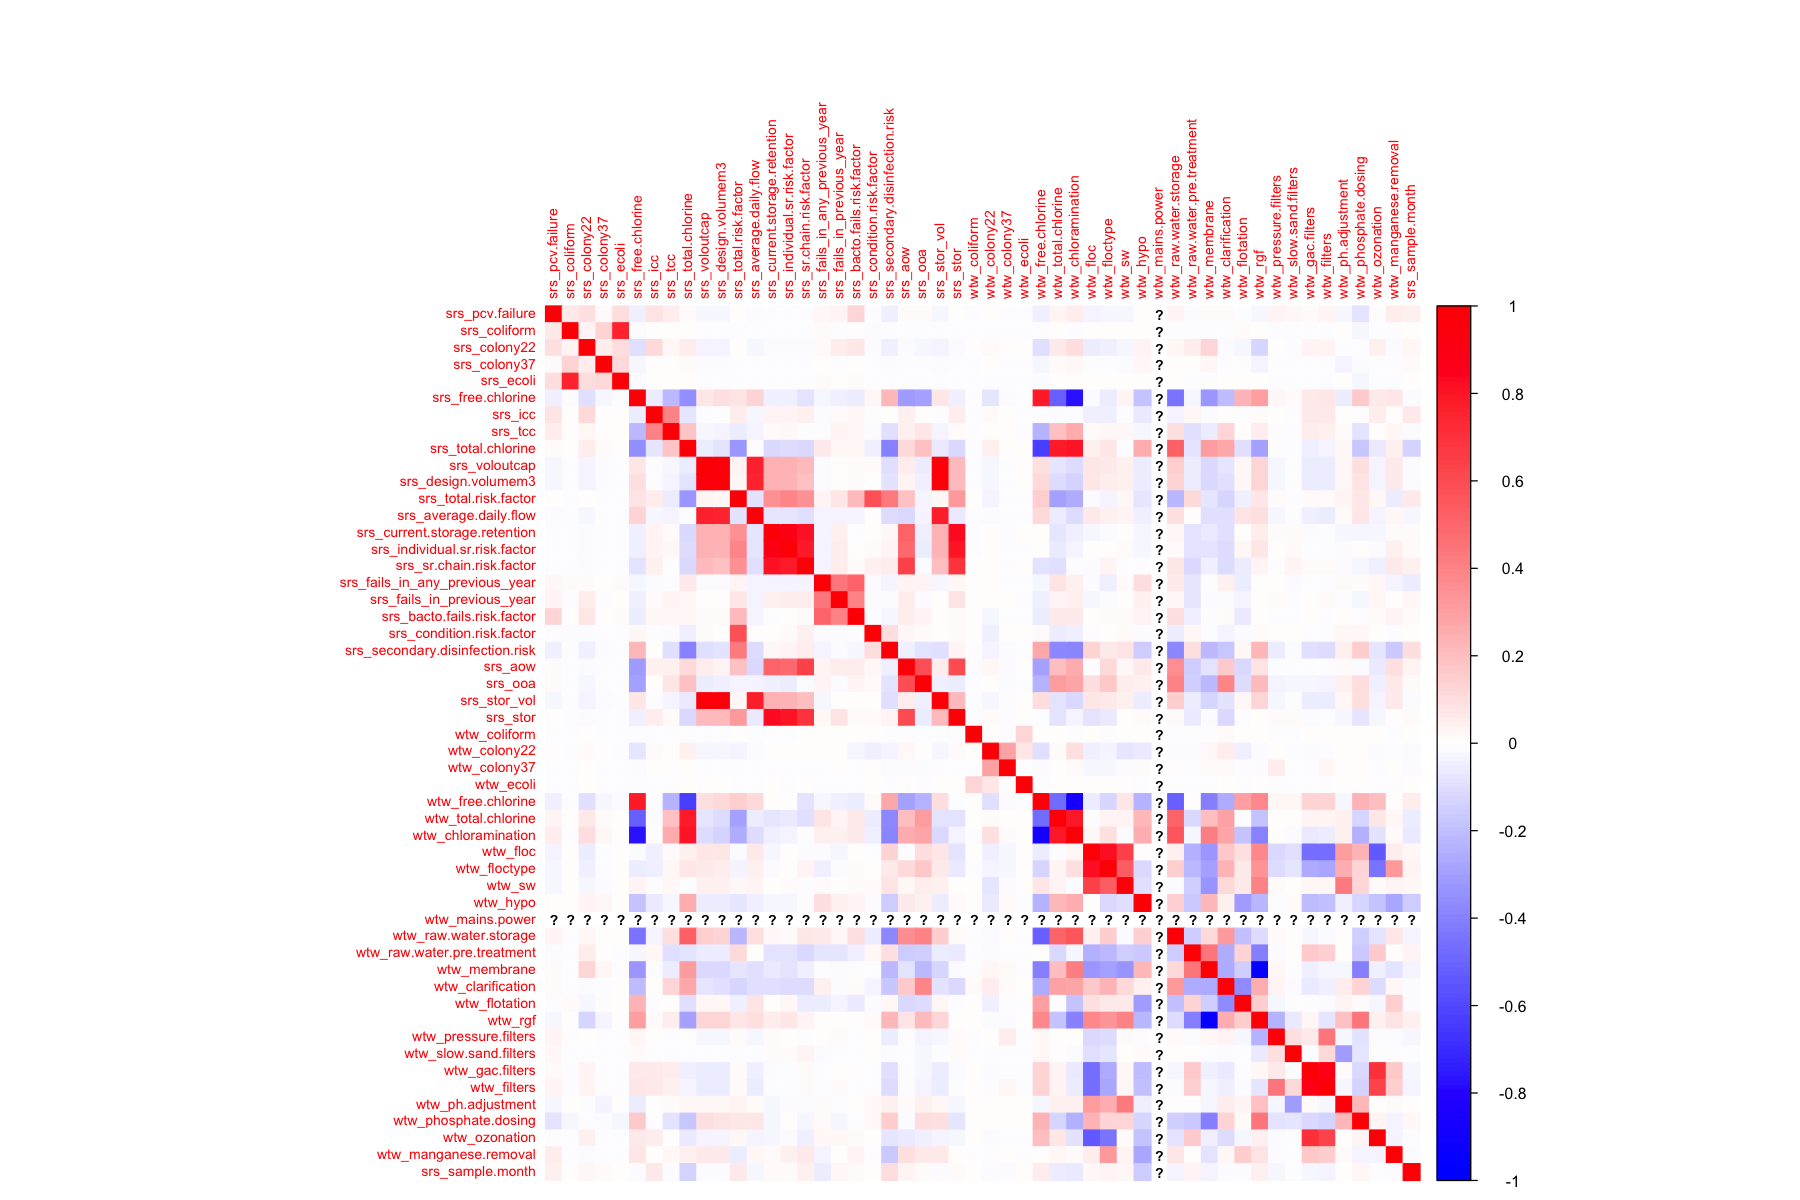

In [99]:
options(repr.plot.width = 15, repr.plot.height = 10)
# Subset the numeric columns excluding the target variable (srs_pcv.failure)
numeric_cols <- sapply(data, is.numeric)
numeric_data <- data[, numeric_cols]

# Compute correlation matrix, excluding srs_pcv.failure
cor_matrix <- cor(numeric_data, use = "pairwise.complete.obs")

# Visualize the correlation matrix using corrplot
corrplot(cor_matrix, method = "color", type = "full", 
         col = colorRampPalette(c("blue", "white", "red"))(200), 
         tl.cex = 0.7, number.cex = 0.7)


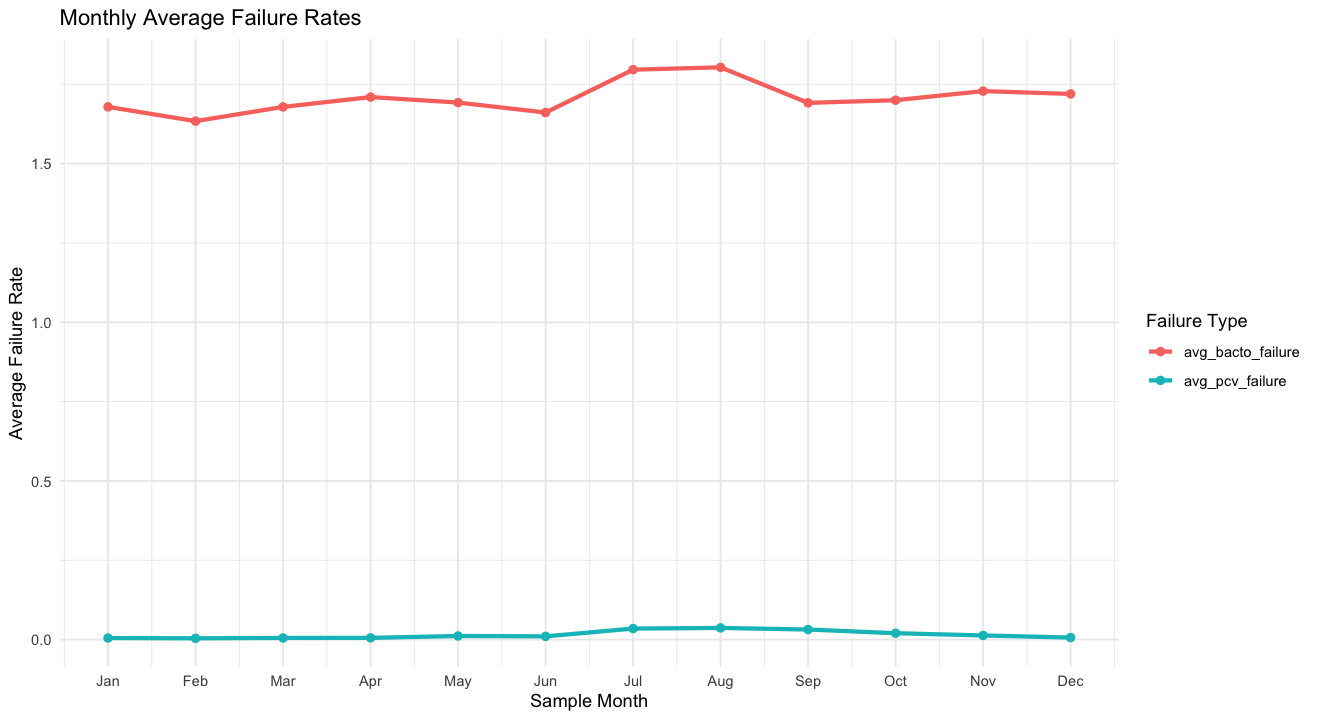

In [41]:
options(repr.plot.width = 11, repr.plot.height = 6)
# Step 1: Summarize the data
month_summary <- df_clean %>%
  group_by(srs_sample.month) %>%
  summarise(
    avg_pcv_failure = mean(srs_pcv.failure, na.rm = TRUE),
    avg_bacto_failure = mean(srs_bacto.fails.risk.factor, na.rm = TRUE)
  )

# Step 2: Reshape the data for plotting the two lines together
month_summary_long <- month_summary %>%
  pivot_longer(cols = c(avg_pcv_failure, avg_bacto_failure),
               names_to = "failure_type",
               values_to = "avg_failure")

# Step 3: Create the plot
graph1 <- ggplot(month_summary_long, aes(x = srs_sample.month, y = avg_failure, color = failure_type)) +
  geom_line(linewidth = 1.2) +  # Replaced 'size' with 'linewidth'
  geom_point(size = 2) +
  scale_x_continuous(breaks = 1:12, labels = month.abb) +  # Labels for the months
  theme_minimal() +
  labs(
    title = "Monthly Average Failure Rates",
    x = "Sample Month",
    y = "Average Failure Rate",
    color = "Failure Type"
  )

# Step 4: Display the plot
print(graph1)

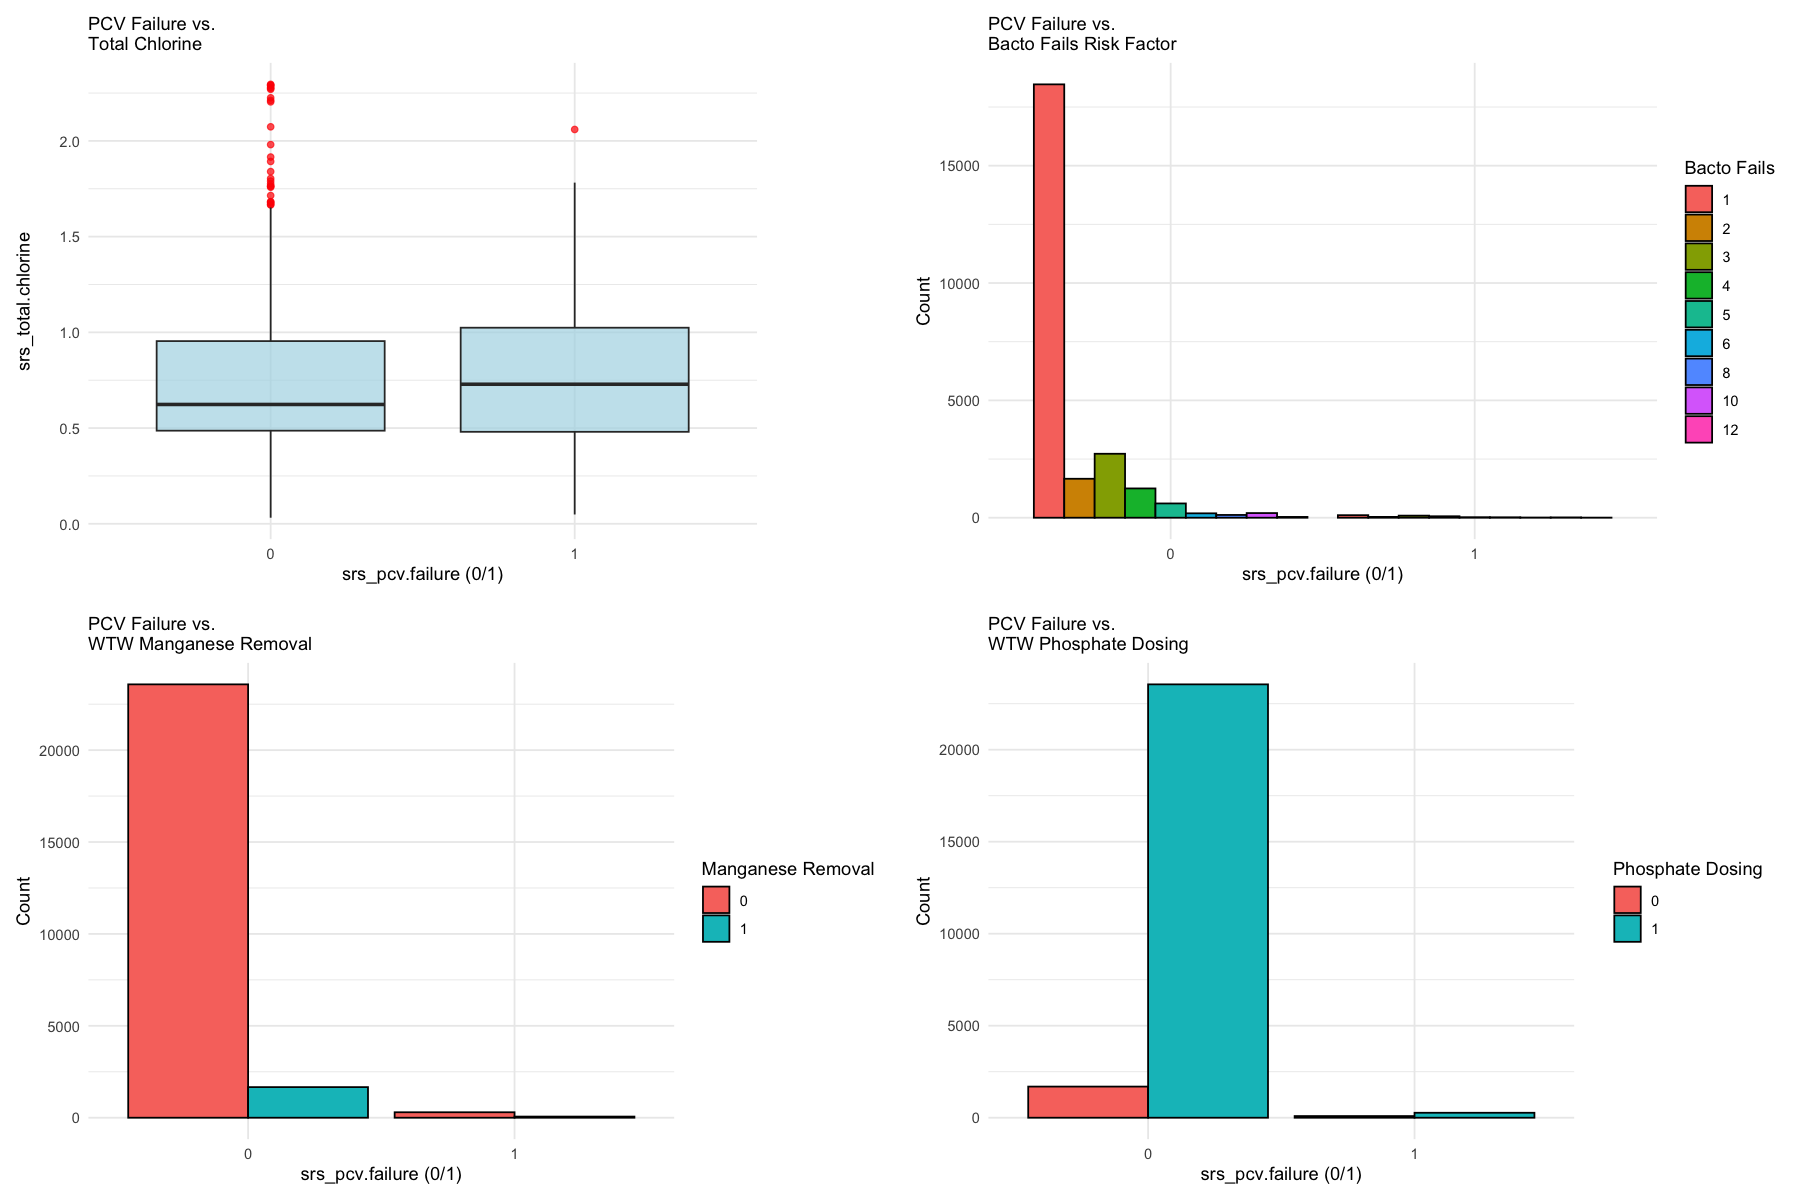

In [43]:
options(repr.plot.width = 15, repr.plot.height = 10)
# A) Box Plot: srs_pcv.failure vs srs_total.chlorine
p1 <- ggplot(df_clean, aes(x = factor(srs_pcv.failure), y = srs_total.chlorine)) +
  geom_boxplot(fill = "lightblue", alpha = 0.7, outlier.color = "red") +
  theme_minimal() +
  labs(
    title = "PCV Failure vs.\nTotal Chlorine",
    x = "srs_pcv.failure (0/1)",
    y = "srs_total.chlorine"
  ) +
  theme(
    plot.title = element_text(size = 11),
    plot.margin = margin(10, 10, 10, 10)
  )

# B) Grouped Bar: srs_pcv.failure vs srs_bacto.fails.risk.factor
p2 <- ggplot(df_clean, aes(x = factor(srs_pcv.failure), fill = factor(srs_bacto.fails.risk.factor))) +
  geom_bar(position = "dodge", color = "black") +
  theme_minimal() +
  labs(
    title = "PCV Failure vs.\nBacto Fails Risk Factor",
    x = "srs_pcv.failure (0/1)",
    y = "Count",
    fill = "Bacto Fails"
  ) +
  theme(
    plot.title = element_text(size = 11),
    plot.margin = margin(10, 10, 10, 10)
  )

# C) Grouped Bar: srs_pcv.failure vs wtw_manganese.removal
p3 <- ggplot(df_clean, aes(x = factor(srs_pcv.failure), fill = factor(wtw_manganese.removal))) +
  geom_bar(position = "dodge", color = "black") +
  theme_minimal() +
  labs(
    title = "PCV Failure vs.\nWTW Manganese Removal",
    x = "srs_pcv.failure (0/1)",
    y = "Count",
    fill = "Manganese Removal"
  ) +
  theme(
    plot.title = element_text(size = 11),
    plot.margin = margin(10, 10, 10, 10)
  )

# D) Grouped Bar: srs_pcv.failure vs wtw_phosphate.dosing
p4 <- ggplot(df_clean, aes(x = factor(srs_pcv.failure), fill = factor(wtw_phosphate.dosing))) +
  geom_bar(position = "dodge", color = "black") +
  theme_minimal() +
  labs(
    title = "PCV Failure vs.\nWTW Phosphate Dosing",
    x = "srs_pcv.failure (0/1)",
    y = "Count",
    fill = "Phosphate Dosing"
  ) +
  theme(
    plot.title = element_text(size = 11),
    plot.margin = margin(10, 10, 10, 10)
  )

# 3. Arrange the first four plots (2x2) with better alignment
# Make two rows of two plots each, then stack them:
row1_set1 <- ggarrange(
  p1, p2,
  ncol = 2, nrow = 1,
  align = "hv"
)

row2_set1 <- ggarrange(
  p3, p4,
  ncol = 2, nrow = 1,
  align = "hv"
)

grid_1 <- ggarrange(
  row1_set1, row2_set1,
  ncol = 1, nrow = 2
)

# Visualize or save
print(grid_1)
# ggsave("first_set_of_four_plots.png", grid_1, width = 10, height = 8, dpi = 300)

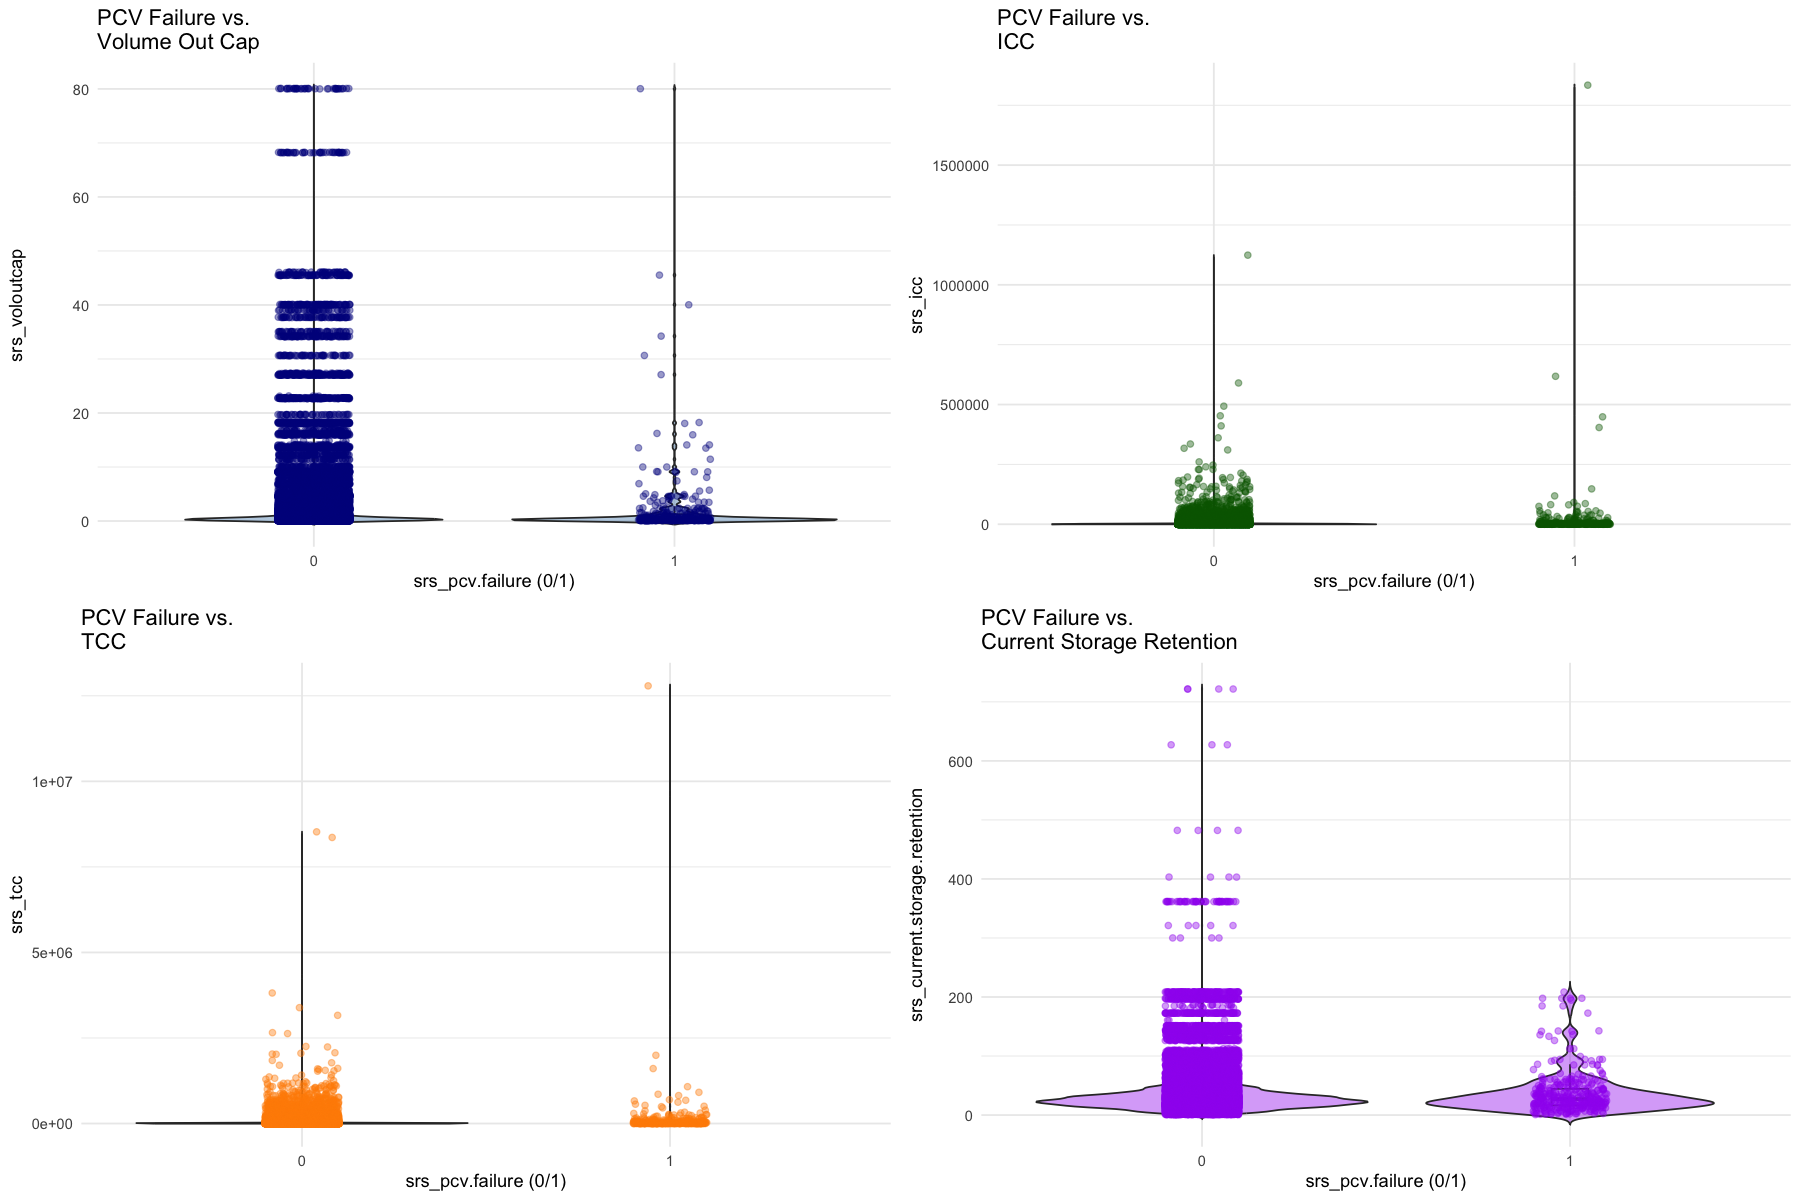

In [47]:
# Example: Replacing Box Plots with Violin+Box+Jitter
# For demonstration, we’ll plot:
#  - srs_voloutcap
#  - srs_icc
#  - srs_tcc
#  - srs_current.storage.retention
#   vs. srs_pcv.failure

# We'll arrange them in a 2x2 layout again using ggarrange.

# 1) PCV Failure vs. Volume Out Cap (Violin + Box + Jitter)
p_voloutcap <- ggplot(df_clean, aes(x = factor(srs_pcv.failure), y = srs_voloutcap)) +
  geom_violin(fill = "steelblue", alpha = 0.4, trim = FALSE) +  
  geom_boxplot(width = 0.1, outlier.shape = NA, alpha = 0.7) + 
  geom_jitter(width = 0.1, alpha = 0.4, color = "darkblue") +
  theme_minimal() +
  labs(
    title = "PCV Failure vs.\nVolume Out Cap",
    x = "srs_pcv.failure (0/1)",
    y = "srs_voloutcap"
  )

# 2) PCV Failure vs. ICC (Violin + Box + Jitter)
p_icc <- ggplot(df_clean, aes(x = factor(srs_pcv.failure), y = srs_icc)) +
  geom_violin(fill = "darkgreen", alpha = 0.4, trim = FALSE) +
  geom_boxplot(width = 0.1, outlier.shape = NA, alpha = 0.7) +
  geom_jitter(width = 0.1, alpha = 0.4, color = "darkgreen") +
  theme_minimal() +
  labs(
    title = "PCV Failure vs.\nICC",
    x = "srs_pcv.failure (0/1)",
    y = "srs_icc"
  )

# 3) PCV Failure vs. TCC (Violin + Box + Jitter)
p_tcc <- ggplot(df_clean, aes(x = factor(srs_pcv.failure), y = srs_tcc)) +
  geom_violin(fill = "orange", alpha = 0.4, trim = FALSE) +
  geom_boxplot(width = 0.1, outlier.shape = NA, alpha = 0.7) +
  geom_jitter(width = 0.1, alpha = 0.4, color = "darkorange") +
  theme_minimal() +
  labs(
    title = "PCV Failure vs.\nTCC",
    x = "srs_pcv.failure (0/1)",
    y = "srs_tcc"
  )

# 4) PCV Failure vs. Current Storage Retention (Violin + Box + Jitter)
p_storage <- ggplot(df_clean, aes(x = factor(srs_pcv.failure), y = srs_current.storage.retention)) +
  geom_violin(fill = "purple", alpha = 0.4, trim = FALSE) +
  geom_boxplot(width = 0.1, outlier.shape = NA, alpha = 0.7) +
  geom_jitter(width = 0.1, alpha = 0.4, color = "purple") +
  theme_minimal() +
  labs(
    title = "PCV Failure vs.\nCurrent Storage Retention",
    x = "srs_pcv.failure (0/1)",
    y = "srs_current.storage.retention"
  )


# Arrange in a 2x2 Grid

row1 <- ggarrange(p_voloutcap, p_icc, ncol = 2, nrow = 1, align = "hv")
row2 <- ggarrange(p_tcc, p_storage, ncol = 2, nrow = 1, align = "hv")

plot_violin_grid <- ggarrange(row1, row2, ncol = 1, nrow = 2)

# Display final arrangement
print(plot_violin_grid)

# Optionally, save to file:
# ggsave("violin_plots_2x2.png", plot_violin_grid, width = 10, height = 8, dpi = 300)

# <======== Logistic Model Creation ========>

In [65]:
install.packages('pRoc')

Warning message:
“package ‘pRoc’ is not available for this version of R

A version of this package for your version of R might be available elsewhere,
see the ideas at
https://cran.r-project.org/doc/manuals/r-patched/R-admin.html#Installing-packages”
Warning message:
“Perhaps you meant ‘pROC’ ?”


In [83]:
library(caret)
#library(pRoc)
set.seed(123)
trainIndex <- createDataPartition(data$srs_pcv.failure, p = 0.7, list = FALSE)
trainData <- data[trainIndex, ]
testData  <- data[-trainIndex, ]

In [59]:
selected_features <- c(
  "srs_bacto.fails.risk.factor",
  "srs_icc",
  "srs_tcc",
  "srs_sample.month",
  "wtw_manganese.removal",
  "wtw_phosphate.dosing",
  "srs_total.risk.factor",
  "srs_fails_in_any_previous_year",
  "srs_aow",
  "srs_free.chlorine",
  "srs_fails_in_previous_year",
  "srs_ooa",
  "srs_total.chlorine",
  "srs_stor_vol",
  "wtw_hypo"
)

In [61]:
# Logistic Regression model training
glm_model <- glm(srs_pcv.failure ~ ., family = binomial, data = trainData[, c(selected_features, "srs_pcv.failure")])

# View model summary explicitly
summary(glm_model)


Call:
glm(formula = srs_pcv.failure ~ ., family = binomial, data = trainData[, 
    c(selected_features, "srs_pcv.failure")])

Coefficients:
                                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)                    -3.675e+00  5.633e-01  -6.523 6.90e-11 ***
srs_bacto.fails.risk.factor     3.400e-01  2.800e-02  12.141  < 2e-16 ***
srs_icc                         5.063e-06  1.580e-06   3.205  0.00135 ** 
srs_tcc                         3.156e-07  2.065e-07   1.528  0.12641    
srs_sample.month                1.013e-01  2.051e-02   4.940 7.81e-07 ***
wtw_manganese.removal           1.370e+00  2.098e-01   6.533 6.44e-11 ***
wtw_phosphate.dosing           -1.358e+00  1.744e-01  -7.787 6.84e-15 ***
srs_total.risk.factor          -1.254e-02  1.054e-02  -1.190  0.23391    
srs_fails_in_any_previous_year -1.827e-01  1.158e-01  -1.578  0.11466    
srs_aow                        -5.567e-02  2.868e-02  -1.941  0.05226 .  
srs_free.chlorine              -1.101e+00  3

In [69]:
glm_pred_class <- factor(ifelse(glm_pred_probs > 0.5, "Fail", "NoFail"),
                         levels = c("NoFail", "Fail"))

In [71]:
# Explicitly verify predictions are not empty
table(glm_pred_class)

glm_pred_class
NoFail   Fail 
  7674      6 

In [85]:
# Step 1: Make predictions on the test set
glm_pred_probs <- predict(glm_model, newdata = testData[, selected_features], type = "response")

# Step 2: Convert probabilities to class predictions
glm_pred_class <- factor(ifelse(glm_pred_probs > 0.5, "Fail", "NoFail"), levels = c("NoFail", "Fail"))

# Step 3: Prepare the reference (true) class
# Ensure the true labels in testData are in the same format
true_labels <- factor(ifelse(testData$srs_pcv.failure == 1, "Fail", "NoFail"), levels = c("NoFail", "Fail"))

# Sanity check
table(glm_pred_class)
table(true_labels)

# Step 4: Compute confusion matrix
library(caret)
confusion_glm <- confusionMatrix(glm_pred_class, true_labels, positive = "Fail")
print(confusion_glm)


glm_pred_class
NoFail   Fail 
  7674      6 

true_labels
NoFail   Fail 
  7572    108 

Confusion Matrix and Statistics

          Reference
Prediction NoFail Fail
    NoFail   7568  106
    Fail        4    2
                                          
               Accuracy : 0.9857          
                 95% CI : (0.9828, 0.9882)
    No Information Rate : 0.9859          
    P-Value [Acc > NIR] : 0.6014          
                                          
                  Kappa : 0.0337          
                                          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 0.0185185       
            Specificity : 0.9994717       
         Pos Pred Value : 0.3333333       
         Neg Pred Value : 0.9861871       
             Prevalence : 0.0140625       
         Detection Rate : 0.0002604       
   Detection Prevalence : 0.0007813       
      Balanced Accuracy : 0.5089951       
                                          
       'Positive' Class : Fail            
                  

Setting levels: control = 0, case = 1

Setting direction: controls < cases



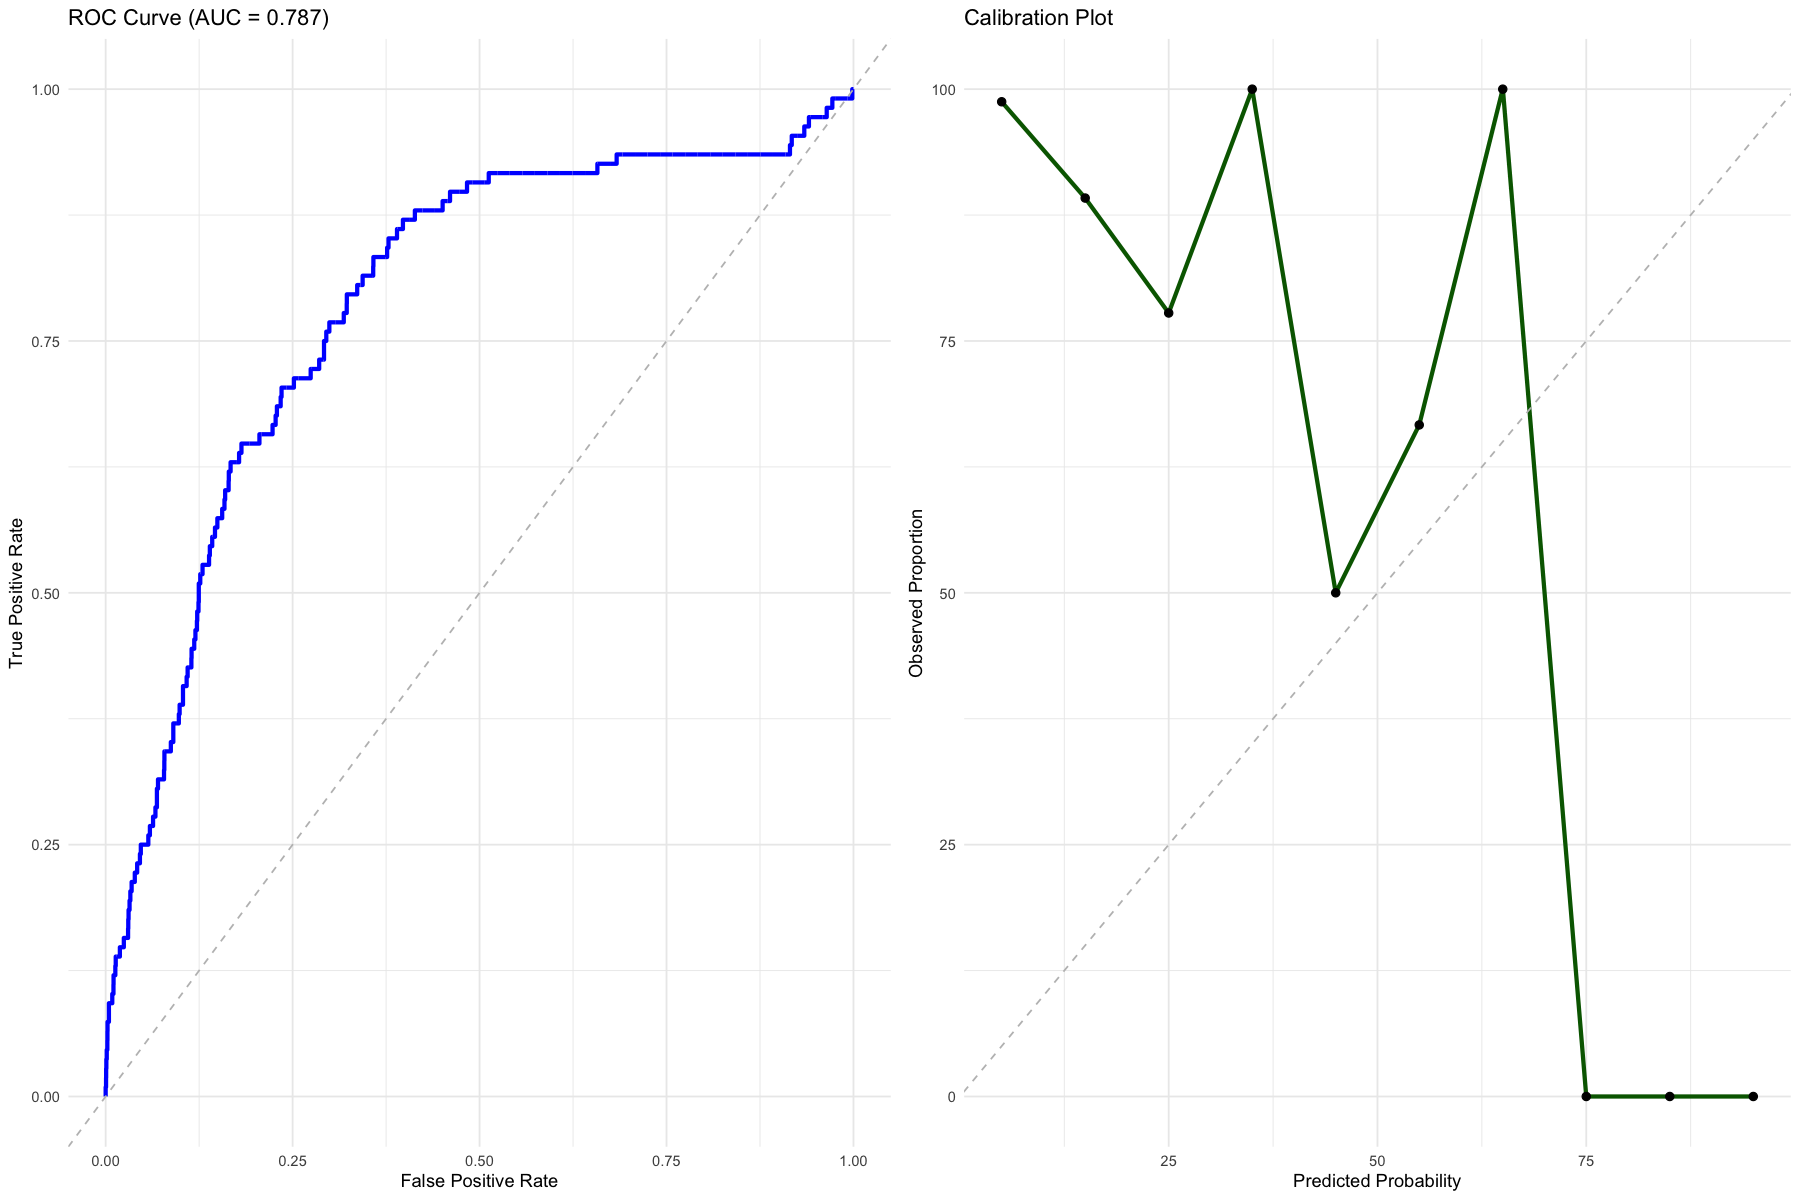

In [95]:
# ROC Curve
roc_obj <- roc(testData$srs_pcv.failure, glm_pred_probs)
roc_df <- data.frame(
  TPR = rev(roc_obj$sensitivities),
  FPR = rev(1 - roc_obj$specificities)
)

roc_plot <- ggplot(roc_df, aes(x = FPR, y = TPR)) +
  geom_line(color = "blue", size = 1.2) +
  geom_abline(linetype = "dashed", color = "gray") +
  theme_minimal() +
  labs(
    title = paste0("ROC Curve (AUC = ", round(auc(roc_obj), 3), ")"),
    x = "False Positive Rate",
    y = "True Positive Rate"
  )

# Calibration Plot
# Create calibration data
cal_data <- data.frame(pred = glm_pred_probs, truth = as.factor(testData$srs_pcv.failure))
cal <- calibration(truth ~ pred, data = cal_data, cuts = 10)

cal_plot <- ggplot(cal$data, aes(x = midpoint, y = Percent)) +
  geom_line(color = "darkgreen", size = 1.2) +
  geom_point(size = 2) +
  geom_abline(slope = 1, intercept = 0, linetype = "dashed", color = "gray") +
  theme_minimal() +
  labs(
    title = "Calibration Plot",
    x = "Predicted Probability",
    y = "Observed Proportion"
  )


# Combine ROC and Calibration Plots
ggarrange(roc_plot, cal_plot, ncol = 2, nrow = 1)
